## Anomaly Detection in Time Series Data using LSTM

In [27]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.1


In [28]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [29]:
print('The dataset contains', df.shape[0], 'entries &', df.shape[1], 'columns')
df.describe()

The dataset contains 8192 entries & 2 columns


,close
count,8192.000000
mean,1070.897411
std,616.714534
min,203.490000
25%,458.632500
50%,1106.435000
75%,1388.132500
max,2872.870000


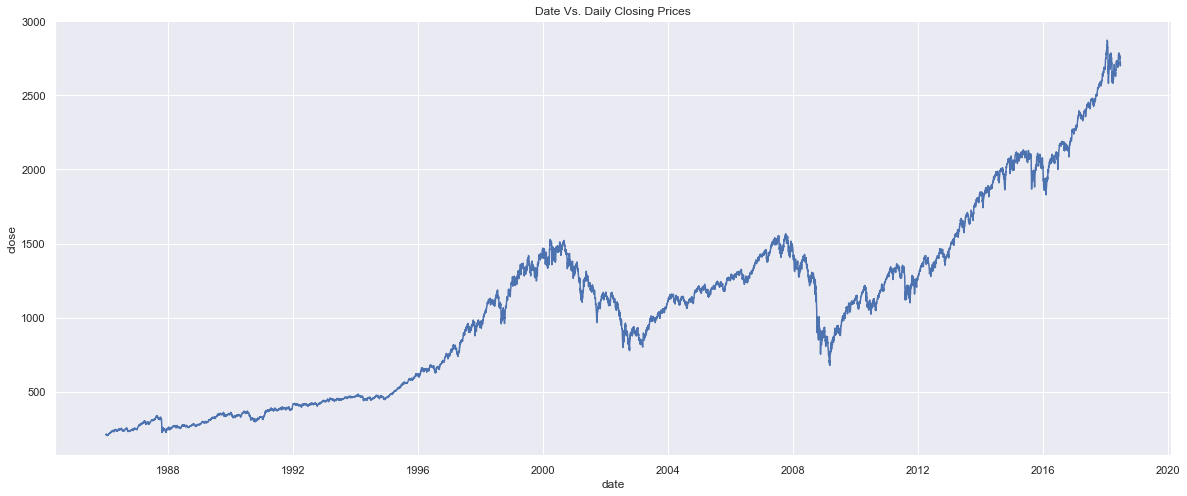

In [30]:
plt.figure(figsize=(20,8))
sns.set(style='darkgrid')
sns.lineplot(x="date", y="close", data=df)
plt.title("Date Vs. Daily Closing Prices")
plt.show()

<Figure size 1440x576 with 0 Axes>

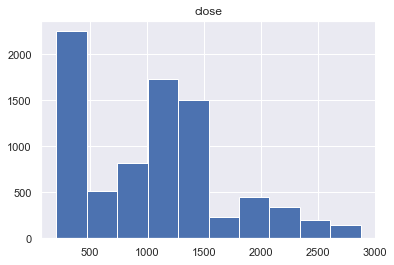

In [31]:
plt.figure(figsize=(20,8))
df.hist()
plt.show()

In [32]:
train_size= int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [33]:
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [34]:
def create_dataset(X,y, time_steps=1):
    Xs, ys = [],[]
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [35]:
time_steps=30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)
print("Shape of x_train: ", X_train.shape)
print('No. of Samples:',X_train.shape[0],'\nNo. of Time Steps:',X_train.shape[1],'\nNo. of Features:',X_train.shape[2 ])

Shape of x_train:  (6523, 30, 1)
No. of Samples: 6523 
No. of Time Steps: 30 
No. of Features: 1


In [36]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [37]:
model = Sequential([
                    LSTM(128, input_shape=(timesteps, num_features)),
                    Dropout(0.2),
                    RepeatVector(timesteps),
                    LSTM(128, return_sequences=True),
                    Dropout(0.2),
                    TimeDistributed(Dense(num_features))])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [38]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
184/184 [==============================] - 21s 114ms/step - loss: 0.1179 - val_loss: 0.0580
Epoch 2/100
184/184 [==============================] - 19s 105ms/step - loss: 0.0720 - val_loss: 0.0405
Epoch 3/100
184/184 [==============================] - 19s 105ms/step - loss: 0.0644 - val_loss: 0.0357
Epoch 4/100
184/184 [==============================] - 19s 106ms/step - loss: 0.0597 - val_loss: 0.0441
Epoch 5/100
184/184 [==============================] - 19s 105ms/step - loss: 0.0569 - val_loss: 0.0315
Epoch 6/100
184/184 [==============================] - 19s 104ms/step - loss: 0.0585 - val_loss: 0.0316
Epoch 7/100
184/184 [==============================] - 19s 104ms/step - loss: 0.0569 - val_loss: 0.0340
Epoch 8/100
184/184 [==============================] - 19s 104ms/step - loss: 0.0552 - val_loss: 0.0302
Epoch 9/100
184/184 [==============================] - 19s 105ms/step - loss: 0.0563 - val_loss: 0.0286
Epoch 10/100
184/184 [==============================] - 19s 103m

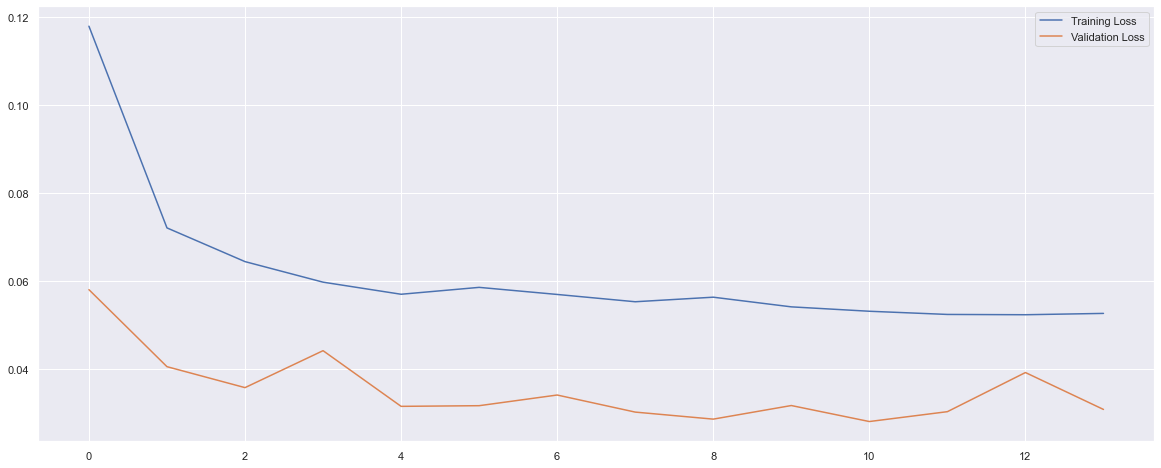

In [39]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [40]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

<AxesSubplot:title={'center':'Distribution of the Test Loss'}>

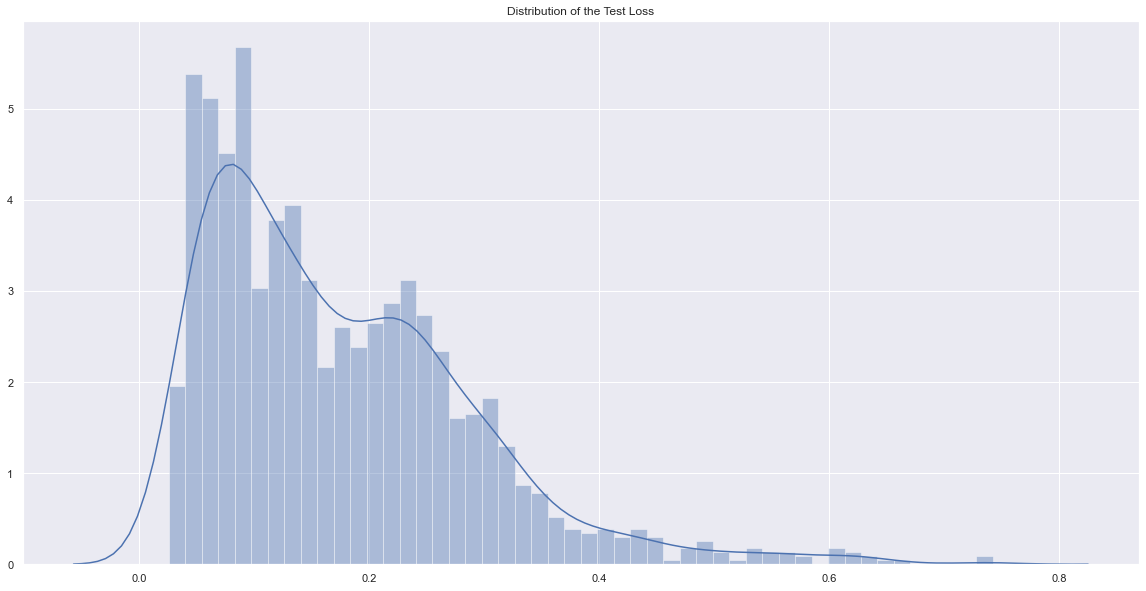

In [41]:
plt.figure(figsize=(20,10))
plt.title('Distribution of the Test Loss')
sns.distplot(test_mae_loss, bins=50, kde=True)

In [42]:
THRESHOLD = 0.75
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [43]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.093235,0.75,False
6584,2012-02-09,1.221625,0.093029,0.75,False
6585,2012-02-10,1.199313,0.090996,0.75,False
6586,2012-02-13,1.221194,0.075707,0.75,False
6587,2012-02-14,1.218150,0.075011,0.75,False


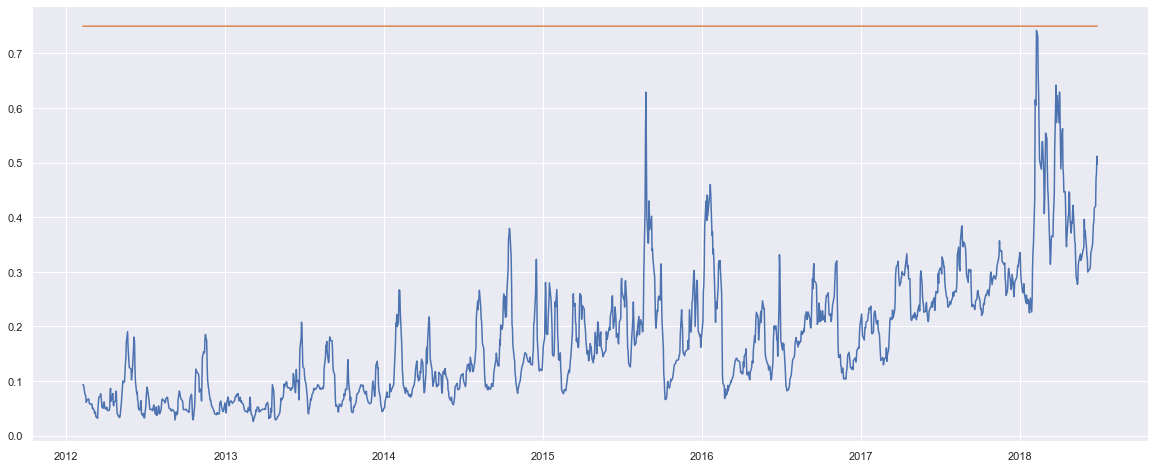

In [44]:
plt.figure(figsize=(20,8))
plt.plot(test[time_steps:].date,test_score_df.loss)
plt.plot(test[time_steps:].date,test_score_df.threshold)
plt.show()

In [45]:
#Creating a Dataframe using only the Anomaly Values
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly


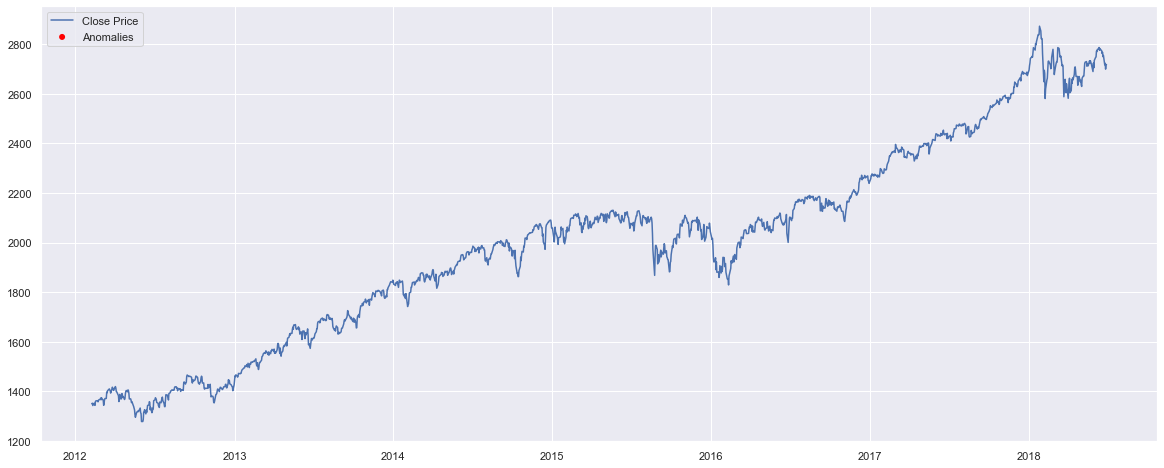

In [46]:
plt.figure(figsize=(20,8))
plt.plot(test[time_steps:].date,scaler.inverse_transform(test[time_steps:].close), label='Close Price')
plt.scatter(anomalies.date,scaler.inverse_transform(anomalies.close), color = 'red', edgecolors='none',label='Anomalies' )
plt.legend(loc = 2)
plt.show()